In [1]:
from delta import configure_spark_with_delta_pip as csp
from pyspark.sql import SparkSession as ss
from pyspark.sql.functions import col
from pyspark.ml.feature import VectorAssembler as va
from pyspark.ml.regression import LinearRegression as lreg
from pyspark.ml.evaluation import RegressionEvaluator as re
import matplotlib.pyplot as plt

In [2]:
scb = (
    ss.builder
        .appName("Prediction") \
        .master("spark://spark-master:7077") \
        .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension")
        .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog") \
        .config("spark.executor.cores", "4") \
        .config("spark.executor.memory", "10g")\
        .config("spark.cores.max", "4") \
)

In [3]:
sprk = csp(scb).getOrCreate()

In [4]:
fp = "/data/delta_output"

In [5]:
df = sprk.read.format("delta").load(fp)

In [6]:
df.count()

50629

In [7]:
df = (
    df.withColumn("active_power", col("signals")["LV ActivePower (kW)"].cast("double"))
      .withColumn("wind_speed", col("signals")["Wind Speed (m/s)"].cast("double"))
      .withColumn("theoretical_curve", col("signals")["Theoretical_Power_Curve (KWh)"].cast("double"))
      .withColumn("wind_direction", col("signals")["Wind Direction (°)"].cast("double"))
)

In [8]:
df = df.na.drop(subset=["active_power", "wind_speed", "theoretical_curve", "wind_direction"])

In [9]:
df.show()
df.count()

+-----------+-------------------+-----------+--------------------+--------------------+----------------+----------------+-----------------+----------------+
|signal_date|          signal_ts|create_date|           create_ts|             signals|    active_power|      wind_speed|theoretical_curve|  wind_direction|
+-----------+-------------------+-----------+--------------------+--------------------+----------------+----------------+-----------------+----------------+
| 2018-01-01|2018-01-01 00:00:00| 2025-04-02|2025-04-02 08:08:...|{LV ActivePower (...|380.047790527343|5.31133604049682| 416.328907824861|259.994903564453|
| 2018-01-01|2018-01-01 00:00:00| 2025-04-02|2025-04-02 08:08:...|{LV ActivePower (...|380.047790527343|5.31133604049682| 416.328907824861|259.994903564453|
| 2018-01-01|2018-01-01 00:10:00| 2025-04-02|2025-04-02 08:08:...|{LV ActivePower (...| 453.76919555664|5.67216682434082| 519.917511061494| 268.64111328125|
| 2018-01-01|2018-01-01 00:10:00| 2025-04-02|2025-04-02 08

50629

In [10]:
feature_cols = ["wind_speed", "theoretical_curve", "wind_direction"]

In [11]:
assembler = va(inputCols=feature_cols, outputCol="features")

In [12]:
assembled = assembler.transform(df).select("signal_date", "signal_ts", "features", "active_power")

In [13]:
train_data, test_data = assembled.randomSplit([0.8, 0.2], seed=42)

In [14]:
train_data.count()

40447

In [15]:
test_data.count()

10182

In [16]:
lr = lreg(featuresCol="features", labelCol="active_power", maxIter=50)

In [17]:
model = lr.fit(train_data)

In [18]:
pre = model.transform(test_data)

In [19]:
eval_rmse = re(
    labelCol="active_power",
    predictionCol="prediction",
    metricName="rmse"
)

In [20]:
eval_r2 = re(
    labelCol="active_power",
    predictionCol="prediction",
    metricName="r2"
)

In [21]:
rmse = eval_rmse.evaluate(pre)

In [22]:
r2 = eval_r2.evaluate(pre)

In [23]:
print(rmse, r2)

397.8495983255787 0.9079090410227442


In [24]:
img = (
    pre
    .select("signal_ts", "active_power", "prediction")
    .orderBy("signal_ts")  # ensure ascending timestamps
    .toPandas()
)

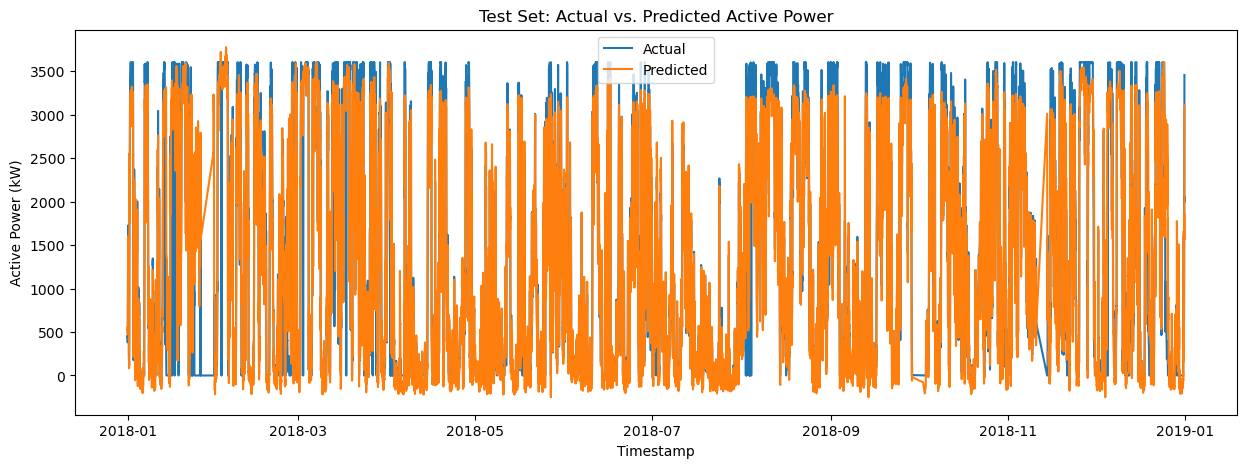

In [25]:
plt.figure(figsize=(15, 5))
plt.plot(img["signal_ts"], img["active_power"], label="Actual")

plt.plot(img["signal_ts"], img["prediction"], label="Predicted")

plt.xlabel("Timestamp")
plt.ylabel("Active Power (kW)")
plt.title("Test Set: Actual vs. Predicted Active Power")

plt.legend()
plt.show()

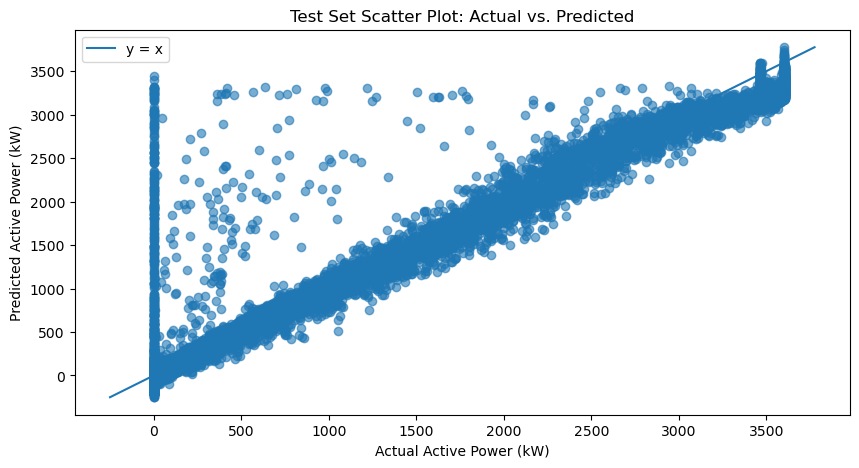

In [26]:
plt.figure(figsize=(10, 5))
plt.scatter(img["active_power"], img["prediction"], alpha=0.6)

# Plot a reference line y = x
min_val = min(img["active_power"].min(), img["prediction"].min())
max_val = max(img["active_power"].max(), img["prediction"].max())
plt.plot([min_val, max_val], [min_val, max_val], label="y = x")

plt.xlabel("Actual Active Power (kW)")
plt.ylabel("Predicted Active Power (kW)")
plt.title("Test Set Scatter Plot: Actual vs. Predicted")
plt.legend()
plt.show()

---

# Predictions

In [27]:
date = "2018-03-22"

In [28]:
future_df = assembled.filter(col("signal_date") == date)

In [29]:
future_preds = model.transform(future_df).select("signal_date", "signal_ts", "active_power", "prediction")

In [30]:
future_preds.show()

+-----------+-------------------+----------------+------------------+
|signal_date|          signal_ts|    active_power|        prediction|
+-----------+-------------------+----------------+------------------+
| 2018-03-22|2018-03-22 00:00:00|290.779205322265|367.31344755501675|
| 2018-03-22|2018-03-22 00:10:00|410.130798339843| 490.9914908269311|
| 2018-03-22|2018-03-22 00:20:00|416.955413818359| 458.0055620704212|
| 2018-03-22|2018-03-22 00:30:00|424.540496826171| 392.2871941445743|
| 2018-03-22|2018-03-22 00:40:00|401.459106445312|380.90437580500395|
| 2018-03-22|2018-03-22 00:50:00|485.445404052734|468.21546643815645|
| 2018-03-22|2018-03-22 01:00:00|532.817626953125|  520.232967124481|
| 2018-03-22|2018-03-22 01:10:00|652.210571289062| 645.4888292326566|
| 2018-03-22|2018-03-22 01:20:00|683.400085449218| 655.2886885855482|
| 2018-03-22|2018-03-22 01:30:00|554.698120117187| 562.8939850849399|
| 2018-03-22|2018-03-22 01:40:00|229.485702514648| 262.3042309213639|
| 2018-03-22|2018-03

In [31]:
img = future_preds.orderBy("signal_ts").toPandas()

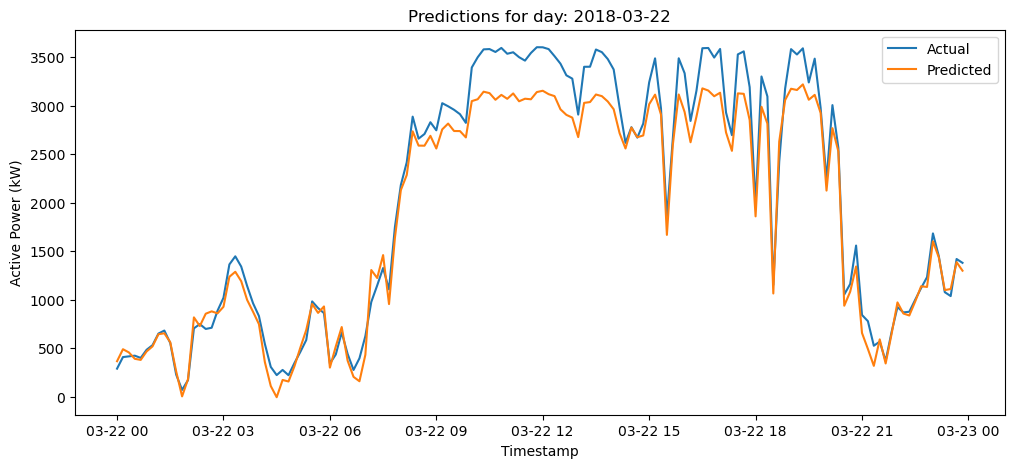

In [32]:
plt.figure(figsize=(12, 5))
plt.plot(img["signal_ts"], img["active_power"], label="Actual")
plt.plot(img["signal_ts"], img["prediction"], label="Predicted")
plt.xlabel("Timestamp")
plt.ylabel("Active Power (kW)")
plt.title(f"Predictions for day: {date}")
plt.legend()
plt.show()

In [33]:
sprk.stop()